## 부탁 드립니다!

본 자료는 패스트캠퍼스 RAG 비법노트 강의에서 유료 강의로 제공되는 자료입니다. 

따라서, 제공된 코드를 사용하여 개발하는 것은 얼마든지 가능합니다만,

**제 3자 에게 무단배포, 웹에 소스코드 게재 및 배포는 금지**하고 있다는 점 부디 양해해 주시기 바랍니다.

개발 및 학습 목적으로만 활용해 주세요. 많은 도움이 되었으면 좋겠습니다. 늘 감사드립니다.

## 환경 설정


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("TeddyNote-Parser", set_enable=False)

LangSmith 추적을 하지 않습니다.


## 이전 단계까지의 내용 재사용

### `upstage_parser_graph` 생성

- `batch_size`: 한번에 처리할 페이지 수
- `test_page`: 테스트할 페이지 번호
- `verbose`: 디버깅 메시지 출력 여부


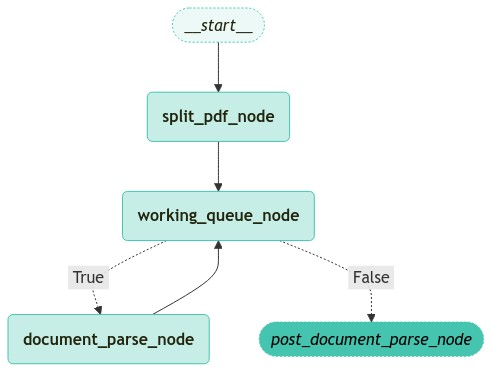

In [3]:
from layoutparse.teddynote_parser import create_upstage_parser_graph

# 그래프 생성
upstage_parser_graph = create_upstage_parser_graph(
    batch_size=30, test_page=None, verbose=True, visualize=True
)

### `upstage_parser_graph` 사용

- `filepath`: 분석할 PDF 파일의 경로

In [4]:
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph

# 옵션 설정
config = RunnableConfig(
    recursion_limit=300,
    configurable={"thread_id": str(uuid.uuid4())},
)

# filepath: 분석할 PDF 파일의 경로
inputs = {
    "filepath": "data/argus-bitumen.pdf",
}

stream_graph(upstage_parser_graph, inputs, config=config)

[SplitPDFNode] 파일의 전체 페이지 수: 21 Pages.
[SplitPDFNode] 분할 PDF 생성: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Start Parsing: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Finished Parsing in 20.78 seconds
[PostDocumentParseNode] Total Post-processed Elements: 465
[PostDocumentParseNode] Total Cost: $0.21


In [5]:
# 추출된 요소들을 확인합니다
elements = upstage_parser_graph.get_state(config).values["elements_from_parser"]
elements[-20:]

[{'category': 'paragraph',
  'content': {'html': "<br><p id='445' data-category='paragraph' style='font-size:14px'>ARGUS, the ARGUS logo, ARGUS MEDIA, INTEGER,<br>ARGUS BITUMEN , other ARGUS publication titles<br>and ARGUS index names are trademarks of Argus<br>Media Limited.<br>Visit www.argusmedia.com/Ft/trademarks for<br>more information.</p>",
   'markdown': 'ARGUS, the ARGUS logo, ARGUS MEDIA, INTEGER,\nARGUS BITUMEN , other ARGUS publication titles\nand ARGUS index names are trademarks of Argus\nMedia Limited.\nVisit www.argusmedia.com/Ft/trademarks for\nmore information.',
   'text': 'ARGUS, the ARGUS logo, ARGUS MEDIA, INTEGER,\nARGUS BITUMEN , other ARGUS publication titles\nand ARGUS index names are trademarks of Argus\nMedia Limited.\nVisit www.argusmedia.com/Ft/trademarks for\nmore information.'},
  'coordinates': [{'x': 0.35, 'y': 0.6126},
   {'x': 0.5765, 'y': 0.6126},
   {'x': 0.5765, 'y': 0.67},
   {'x': 0.35, 'y': 0.67}],
  'id': 445,
  'page': 20},
 {'category': 'para

## Export 처리 로직 구성

이전 단계의 State 를 재사용하기 때문에 **모듈 단위로 이어서 개발하기가 용이**합니다.

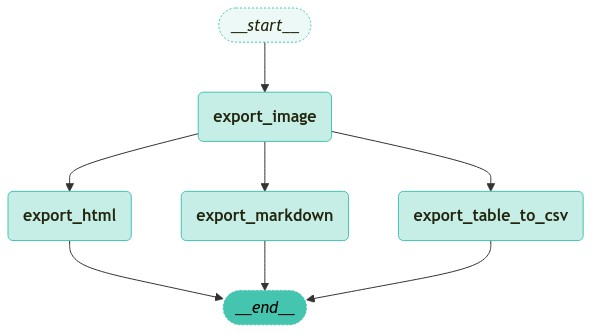

In [6]:
# 그래프 처리를 위한 필수 라이브러리들을 임포트합니다
from langgraph.graph import StateGraph, END
from layoutparse.state import ParseState
import layoutparse.export as export
from langchain_teddynote.graphs import visualize_graph

"""
후처리 워크플로우를 생성하고 관리하는 클래스입니다.
이미지, HTML, 마크다운, CSV 등 다양한 포맷으로 변환하는 작업을 처리합니다.
"""

# ParseState를 상태 관리자로 사용하는 StateGraph 인스턴스를 생성합니다
export_workflow = StateGraph(ParseState)

# 각각의 export 컴포넌트들을 verbose 모드로 초기화합니다
export_image = export.ExportImage(verbose=True)  # 이미지 export 담당
export_html = export.ExportHTML(verbose=True)  # HTML export 담당
export_markdown = export.ExportMarkdown(verbose=True)  # 마크다운 export 담당
export_table_csv = export.ExportTableCSV(verbose=True)  # CSV export 담당

# 워크플로우에 각 컴포넌트들을 노드로 추가합니다
export_workflow.add_node("export_image", export_image)
export_workflow.add_node("export_html", export_html)
export_workflow.add_node("export_markdown", export_markdown)
export_workflow.add_node("export_table_to_csv", export_table_csv)

# export_image 노드에서 다른 노드들로 연결되는 엣지를 추가합니다
export_workflow.add_edge("export_image", "export_html")
export_workflow.add_edge("export_image", "export_markdown")
export_workflow.add_edge("export_image", "export_table_to_csv")

# 각 export 노드에서 END로 연결되는 엣지를 추가합니다
export_workflow.add_edge("export_html", END)
export_workflow.add_edge("export_markdown", END)
export_workflow.add_edge("export_table_to_csv", END)

# 워크플로우의 시작점을 export_image로 설정합니다
export_workflow.set_entry_point("export_image")

# 워크플로우를 컴파일하고 시각화합니다
export_graph = export_workflow.compile()
visualize_graph(export_graph)

In [8]:
# 이전 단계의 실행 결과를 사용합니다
previous_state = upstage_parser_graph.get_state(config).values

In [9]:
# 추출된 요소들을 확인합니다
previous_state["elements_from_parser"][:10]

[{'category': 'paragraph',
  'content': {'html': "<p id='0' data-category='paragraph' style='font-size:20px'>Europe, Africa, Middle East and Asia-Pacific prices and commentary<br>Incorporating Argus Asphalt Report</p>",
   'markdown': 'Europe, Africa, Middle East and Asia-Pacific prices and commentary\nIncorporating Argus Asphalt Report',
   'text': 'Europe, Africa, Middle East and Asia-Pacific prices and commentary\nIncorporating Argus Asphalt Report'},
  'coordinates': [{'x': 0.3217, 'y': 0.1249},
   {'x': 0.9273, 'y': 0.1249},
   {'x': 0.9273, 'y': 0.156},
   {'x': 0.3217, 'y': 0.156}],
  'id': 0,
  'page': 0},
 {'category': 'paragraph',
  'content': {'html': "<p id='1' data-category='paragraph' style='font-size:20px'>SUMMARY</p>",
   'markdown': 'SUMMARY',
   'text': 'SUMMARY'},
  'coordinates': [{'x': 0.0733, 'y': 0.2237},
   {'x': 0.1626, 'y': 0.2237},
   {'x': 0.1626, 'y': 0.2374},
   {'x': 0.0733, 'y': 0.2374}],
  'id': 1,
  'page': 0},
 {'category': 'paragraph',
  'content': {

In [10]:
# 이전 단계의 실행 결과를 복사하여 입력으로 사용합니다
inputs = previous_state.copy()

매번 최신 코드를 반영하기 위한 `importlib` 

In [27]:
import importlib

# export 모듈을 새로 리로드하여 최신 상태를 유지합니다
importlib.reload(export)

# 각각의 export 컴포넌트들을 verbose 모드로 초기화합니다
export_image = export.ExportImage(verbose=True)
export_html = export.ExportHTML(verbose=True, ignore_new_line_in_text=True)
export_markdown = export.ExportMarkdown(
    verbose=True, ignore_new_line_in_text=True, show_image=False
)
export_table_csv = export.ExportTableCSV(verbose=True)

단계별 상태를 업데이트 후 반영합니다.

In [16]:
inputs2 = export_image(inputs)
inputs.update(inputs2)

In [12]:
# 반영된 결과
inputs["elements_from_parser"][-30:-25]

[{'category': 'list',
  'content': {'html': "<br><p id='435' data-category='list' style='font-size:16px'>•\t News<br>•\t Prices\t<br>•\t Commentary<br>•\t Data\tand\t\t<br>downloads</p>",
   'markdown': '- •\t News\n- •\t Prices\t\n- •\t Commentary\n- •\t Data\tand\t\t\n- downloads\n',
   'text': '•\t News\n•\t Prices\t\n•\t Commentary\n•\t Data\tand\t\t\ndownloads'},
  'coordinates': [{'x': 0.5489, 'y': 0.301},
   {'x': 0.6592, 'y': 0.301},
   {'x': 0.6592, 'y': 0.3881},
   {'x': 0.5489, 'y': 0.3881}],
  'id': 435,
  'page': 20},
 {'base64_encoding': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIALIBSAMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw

In [22]:
export_html(inputs)

[ExportHTML] HTML 파일이 성공적으로 생성되었습니다: data/argus-bitumen.html


{'export': ['data/argus-bitumen.html']}

입력으로 들어가는 상태 확인

In [23]:
inputs["elements_from_parser"][0]

{'category': 'paragraph',
 'content': {'html': "<p id='0' data-category='paragraph' style='font-size:20px'>Europe, Africa, Middle East and Asia-Pacific prices and commentary<br>Incorporating Argus Asphalt Report</p>",
  'markdown': 'Europe, Africa, Middle East and Asia-Pacific prices and commentary\nIncorporating Argus Asphalt Report',
  'text': 'Europe, Africa, Middle East and Asia-Pacific prices and commentary\nIncorporating Argus Asphalt Report'},
 'coordinates': [{'x': 0.3217, 'y': 0.1249},
  {'x': 0.9273, 'y': 0.1249},
  {'x': 0.9273, 'y': 0.156},
  {'x': 0.3217, 'y': 0.156}],
 'id': 0,
 'page': 0}

### Markdown

In [28]:
export_markdown(inputs)

[ExportMarkdown] 마크다운 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/argus-bitumen.md


{'export': ['/Users/teddy/Dev/github/teddynote-parser-v2/data/argus-bitumen.md']}

### CSV

In [29]:
export_table_csv(inputs)

[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_0_Index_10.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_0_Index_14.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_1_Index_26.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_1_Index_29.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_2_Index_47.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_2_Index_51.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_2_Index_52.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/t

{'elements_from_parser': [{'category': 'paragraph',
   'content': {'html': "<p id='0' data-category='paragraph' style='font-size:20px'>Europe, Africa, Middle East and Asia-Pacific prices and commentary<br>Incorporating Argus Asphalt Report</p>",
    'markdown': 'Europe, Africa, Middle East and Asia-Pacific prices and commentary\nIncorporating Argus Asphalt Report',
    'text': 'Europe, Africa, Middle East and Asia-Pacific prices and commentary\nIncorporating Argus Asphalt Report'},
   'coordinates': [{'x': 0.3217, 'y': 0.1249},
    {'x': 0.9273, 'y': 0.1249},
    {'x': 0.9273, 'y': 0.156},
    {'x': 0.3217, 'y': 0.156}],
   'id': 0,
   'page': 0},
  {'category': 'paragraph',
   'content': {'html': "<p id='1' data-category='paragraph' style='font-size:20px'>SUMMARY</p>",
    'markdown': 'SUMMARY',
    'text': 'SUMMARY'},
   'coordinates': [{'x': 0.0733, 'y': 0.2237},
    {'x': 0.1626, 'y': 0.2237},
    {'x': 0.1626, 'y': 0.2374},
    {'x': 0.0733, 'y': 0.2374}],
   'id': 1,
   'page': 0